In [10]:
import os
import torch
import json
from torch.utils.data import DataLoader
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from data import load_data
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from util import cross_entropy_loss_fn, plot_samples, compute_nlls, OOD_detection, get_epsilon, sample_model, compute_KID, extract_features, preprocess_samples
import numpy as np
from precision_recall import prd_score
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import re
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test LL

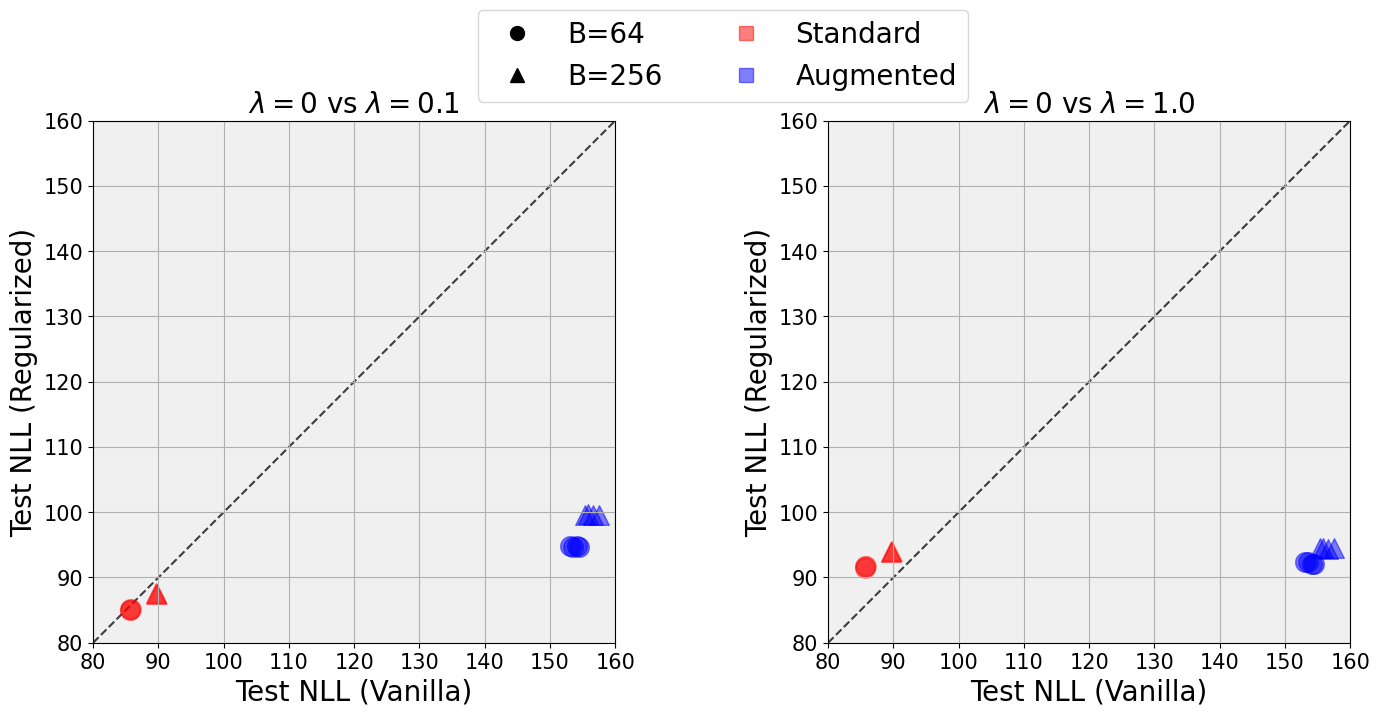

In [40]:
# Define the result directory
result_dir = 'results_made'

# Regular expression pattern to match the directory names and extract hyperparameters
pattern = re.compile(
    r"(?P<datetime>\d{8}_\d{6})_"
    r"S(?P<seed>\d+)_"
    r"E(?P<num_epochs>\d+)_"
    r"BS(?P<batch_size>\d+)_"
    r"LR(?P<lr>[\de.-]+)_"
    r"NM(?P<n_masks>\d+)_"
    r"HL(?P<M>\d+)_"
    r"ID(?P<input_dim>\d+)_"
    r"(?P<data>[^_]+)_"
    r"BIN_"
    r"LAM(?P<lam>[\de.-]+)_"
    r"PAT(?P<patience>\d+)"
)

directories = os.listdir(result_dir)
data_dict = defaultdict(lambda: defaultdict(dict))

# Extract nll_val from directories and organize by batch_size and lam
for directory in directories:
    match = pattern.match(directory)
    if match:
        params = match.groupdict()
        batch_size = int(params['batch_size'])
        lam = float(params['lam'])
        if batch_size in [64, 256] and lam in [0, 0.1, 1.0]:
            results_path = os.path.join(result_dir, directory, 'results.json')
            if os.path.exists(results_path):
                with open(results_path, 'r') as f:
                    results = json.load(f)
                    test_nll = results.get('test_val')
                    aug_test_nll = results.get('aug_test_val')
                    nll_val = results.get('nll_val')
                    if test_nll is not None and aug_test_nll is not None:
                        seed = int(params['seed'])
                        data_dict[batch_size][lam][seed] = (test_nll, aug_test_nll, nll_val)

plt.rcParams.update({
    'font.size': 20,          # Global font size
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 20,     # X and Y axis labels font size
    'xtick.labelsize': 15,    # X-axis tick labels font size
    'ytick.labelsize': 15,    # Y-axis tick labels font size
    'legend.fontsize': 20,    # Legend font size
})
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

# Define colors for standard and augmented results
color_standard = 'red'
color_augmented = 'blue'

# Create scatter plots in a 1x2 grid
fig1, axs1 = plt.subplots(1, 2, figsize=(15, 7))

batch_sizes = [64, 256]
lams = [0.1, 1.0]
markers = ['o', '^']  # Different markers for different batch sizes ('o' for 64, '^' for 256)

# Determine global limits for all subplots
all_nll = []
for batch_size in batch_sizes:
    for lam in lams:
        for seed in data_dict[batch_size][lam].keys():
            test_nll, aug_test_nll, _ = data_dict[batch_size][lam][seed]
            all_nll.append(test_nll)
            all_nll.append(aug_test_nll)
global_min = 80  # You can uncomment the next line if you want to determine min dynamically
# global_min = min(all_nll)
global_max = 160  # You can uncomment the next line if you want to determine max dynamically
# global_max = max(all_nll)

# Plot for each lambda value
for j, lam in enumerate(lams):
    ax = axs1[j]
    for i, batch_size in enumerate(batch_sizes):
        seeds = set(data_dict[batch_size][0].keys()) & set(data_dict[batch_size][lam].keys())
        for seed in seeds:
            test_nll_0, aug_test_nll_0, _ = data_dict[batch_size][0][seed]
            test_nll_lam, aug_test_nll_lam, _ = data_dict[batch_size][lam][seed]
            # Transparent for standard
            ax.scatter(test_nll_0, test_nll_lam, color=color_standard, marker=markers[i], s=200, label=f'Seed {seed} (B={batch_size})', alpha = 0.3)
            # Opaque for augmented
            ax.scatter(aug_test_nll_0, aug_test_nll_lam, color=color_augmented, marker=markers[i], s=200, alpha = 0.5)
    ax.set_title(f'$\\lambda = 0$ vs $\\lambda = {lam}$')
    ax.set_facecolor('#f0f0f0')
    ax.set_xlabel('Test NLL (Vanilla)')
    ax.set_ylabel('Test NLL (Regularized)')
    # Add y=x dashed line
    lims = [global_min, global_max]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.grid(True)

# Create a single legend for all plots
handles = [
    plt.Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=10, label='B=64'),
    plt.Line2D([0], [0], marker='^', color='black', linestyle='None', markersize=10, label='B=256'),
    plt.Line2D([0], [0], marker='s', color=color_standard, linestyle='None', markersize=10, label='Standard', alpha = 0.5),
    plt.Line2D([0], [0], marker='s', color=color_augmented, linestyle='None', markersize=10, label='Augmented', alpha = 0.5)
]
fig1.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.522, 1.05))
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot as an SVG file
plt.savefig('images/made/test_scatter_made_mnist.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


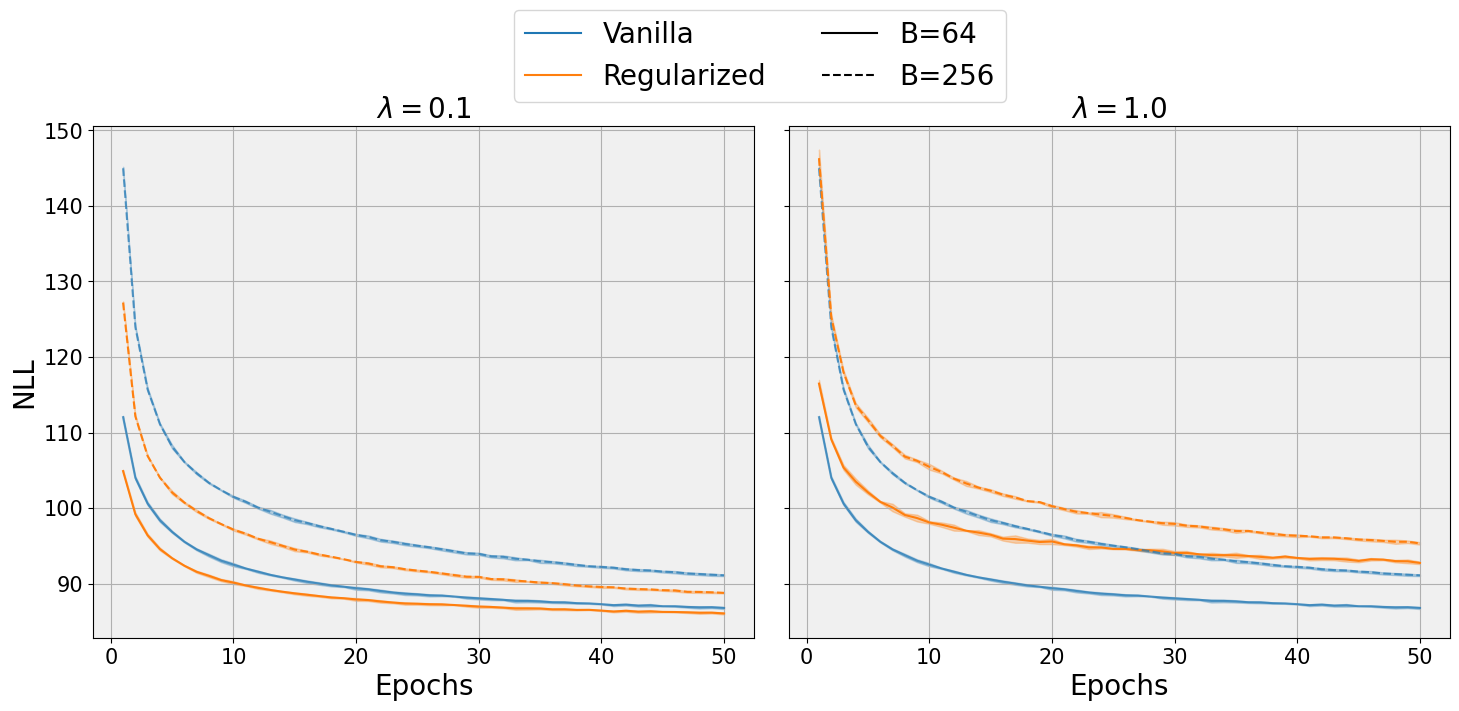

In [32]:
# Function to calculate mean and standard deviation across seeds
def get_mean_and_std(data_dict, batch_size, lam, epochs):
    nll_vals = np.array([data_dict[batch_size][lam][seed][2] for seed in data_dict[batch_size][lam]])
    mean = np.mean(nll_vals, axis=0)
    std = np.std(nll_vals, axis=0)
    return mean, std

# Create a 1x2 grid for the plots
fig2, axs2 = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)

batch_sizes = [64, 256]
lams = [0.1, 1.0]
colors = ['#1f77b4', '#ff7f0e']  # Blue for Vanilla, Orange for Regularized

# Plot for each lambda value
for j, lam in enumerate(lams):
    ax = axs2[j]
    for i, batch_size in enumerate(batch_sizes):
        seeds = sorted(set(data_dict[batch_size][0].keys()) & set(data_dict[batch_size][lam].keys()))
        if seeds:
            epochs = len(data_dict[batch_size][0][seeds[0]][2])
            mean_nll_0, std_nll_0 = get_mean_and_std(data_dict, batch_size, 0, epochs)
            mean_nll_lam, std_nll_lam = get_mean_and_std(data_dict, batch_size, lam, epochs)
            
            # Plot mean and fill between mean ± std for vanilla (lambda = 0)
            ax.plot(range(1, epochs + 1), mean_nll_0, color=colors[0], linestyle='--' if batch_size == 256 else '-', alpha=0.7, label=f'Vanilla (B={batch_size})' if lam == 0 and i == 0 else "")
            ax.fill_between(range(1, epochs + 1), mean_nll_0 - std_nll_0, mean_nll_0 + std_nll_0, color=colors[0], alpha=0.3)
            
            # Plot mean and fill between mean ± std for regularized (lambda > 0)
            ax.plot(range(1, epochs + 1), mean_nll_lam, color=colors[1], linestyle='-' if batch_size == 64 else '--', alpha=1, label=f'Regularized (B={batch_size})' if lam > 0 and i == 0 else "")
            ax.fill_between(range(1, epochs + 1), mean_nll_lam - std_nll_lam, mean_nll_lam + std_nll_lam, color=colors[1], alpha=0.3)
            
    ax.set_title(f'$\\lambda = {lam}$')
    ax.set_xlabel('Epochs')
    ax.set_facecolor('#f0f0f0')
    if j == 0:
        ax.set_ylabel('NLL')
    ax.grid(True)

# Create a single legend for all plots
handles = [
    plt.Line2D([0], [0], color=colors[0], label='Vanilla'),
    plt.Line2D([0], [0], color=colors[1], label='Regularized'),
    plt.Line2D([0], [0], linestyle='-', color='#000000', label='B=64'),
    plt.Line2D([0], [0], linestyle='--', color='#000000', label='B=256')
]
fig2.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.52, 1.05))

# Add a title for the entire figure
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot as an SVG file
plt.savefig('images/made/val_loss_curve_made_mnist.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



In [ ]:
result_dir_vanilla = 'results_made/20240718_203150_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM0.0_PAT10_MOD/'
result_dir_reg = 'results_made/20240718_210453_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM0.1_PAT10_MOD/'
result_dir_reg_plus = 'results_made/20240718_230620_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM1.0_PAT10_MOD/'

model_vanilla = torch.load(result_dir_vanilla + 'model_best.model', map_location=torch.device('cpu')).to(device)
model_vanilla.eval()
with open(result_dir_vanilla + 'evaluate_results.json', 'r') as file:
    eval_dic_vanilla = json.load(file)

model_reg = torch.load(result_dir_reg + 'model_best.model', map_location=torch.device('cpu')).to(device)
model_reg.eval()
with open(result_dir_reg + 'evaluate_results.json', 'r') as file:
    eval_dic_reg = json.load(file)

model_reg_plus = torch.load(result_dir_reg_plus + 'model_best.model', map_location=torch.device('cpu')).to(device)
model_reg_plus.eval()
with open(result_dir_reg_plus + 'evaluate_results.json', 'r') as file:
    eval_dic_reg_plus = json.load(file)

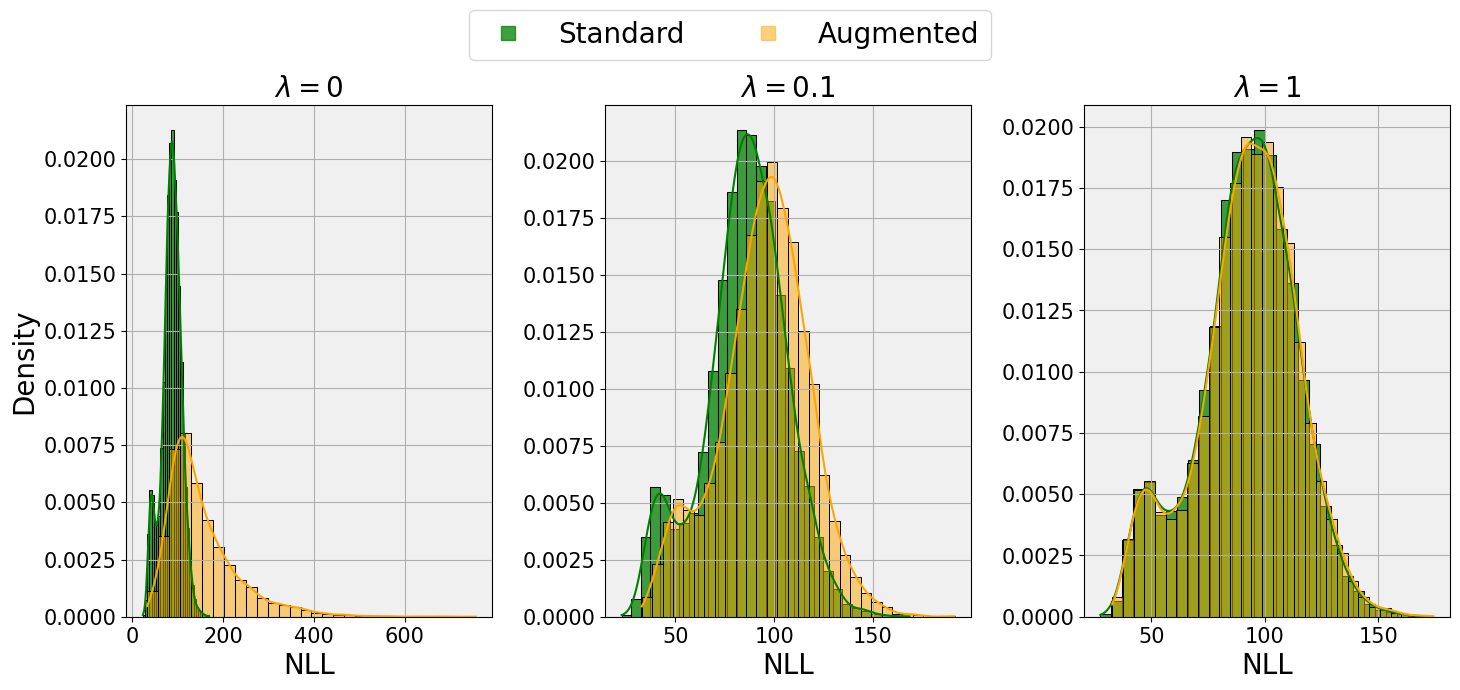

In [22]:
if os.path.exists(result_dir + '/plots' + '/results_64.json'):
    file_path = result_dir + '/plots' + '/results_64.json'
    with open(file_path, 'r') as file:
        results = json.load(file)
    test_lls_vanilla = results['test']['test_lls_vanilla']
    train_lls_vanilla = results['train']['train_lls_vanilla']
    test_lls_vanilla_aug = results['test']['test_lls_vanilla_aug']
    test_lls_regularized = results['test']['test_lls_regularized']
    train_lls_regularized = results['train']['train_lls_regularized']
    test_lls_regularized_aug = results['test']['test_lls_regularized_aug']
    test_lls_regularized_plus = results['test']['test_lls_regularized_plus']
    train_lls_regularized_plus = results['train']['train_lls_regularized_plus']
    test_lls_regularized_plus_aug = results['test']['test_lls_regularized_plus_aug']
    test_diffs_vanilla = results['test']['test_diffs_vanilla']
    test_diffs_regularized = results['test']['test_diffs_regularized']
    test_diffs_regularized_plus = results['test']['test_diffs_regularized_plus']

else:
    #test_lls_vanilla = eval_dic_vanilla['OOD_NLLs_test']['mnist']
    #train_lls_vanilla = eval_dic_vanilla['train_nll_mnist']
    #test_lls_vanilla_aug = eval_dic_vanilla['aug_nll_mnist']
    #test_lls_regularized = eval_dic_reg['OOD_NLLs_test']['mnist']
    #train_lls_regularized = eval_dic_reg['train_nll_mnist']
    #test_lls_regularized_aug = eval_dic_reg['aug_nll_mnist']
    #test_lls_regularized_plus = eval_dic_reg_plus['OOD_NLLs_test']['mnist']
    #train_lls_regularized_plus = eval_dic_reg_plus['train_nll_mnist']
    #test_lls_regularized_plus_aug = eval_dic_reg_plus['aug_nll_mnist']
    
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot histograms
sns.histplot(np.array(test_lls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0])
sns.histplot(np.array(test_lls_vanilla_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0])
axs[0].set_title('$\lambda = 0$')
axs[0].set_xlabel('NLL')
axs[0].set_ylabel('Density')  # Keep y-axis label for the first subplot
axs[0].set_facecolor('#f0f0f0')
axs[0].grid(True)

sns.histplot(np.array(test_lls_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1])
sns.histplot(np.array(test_lls_regularized_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1])
axs[1].set_title('$\lambda = 0.1$')
axs[1].set_xlabel('NLL')
axs[1].set_ylabel('')  # Remove y-axis label for the second subplot
axs[1].set_facecolor('#f0f0f0')
axs[1].grid(True)

sns.histplot(np.array(test_lls_regularized_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[2])
sns.histplot(np.array(test_lls_regularized_plus_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[2])
axs[2].set_title('$\lambda = 1$')
axs[2].set_xlabel('NLL')
axs[2].set_ylabel('')  # Remove y-axis label for the third subplot
axs[2].set_facecolor('#f0f0f0')
axs[2].grid(True)

# Create a single legend for all subplots
handles = [
    plt.Line2D([0], [0], linestyle='None', marker='s', color='green', markersize=10, alpha=0.75, label='Standard'),
    plt.Line2D([0], [0], linestyle='None', marker='s', color='orange', markersize=10, alpha=0.5, label='Augmented')
]

fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot as an SVG file
plt.savefig('images/made/aug_hist_made_64.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

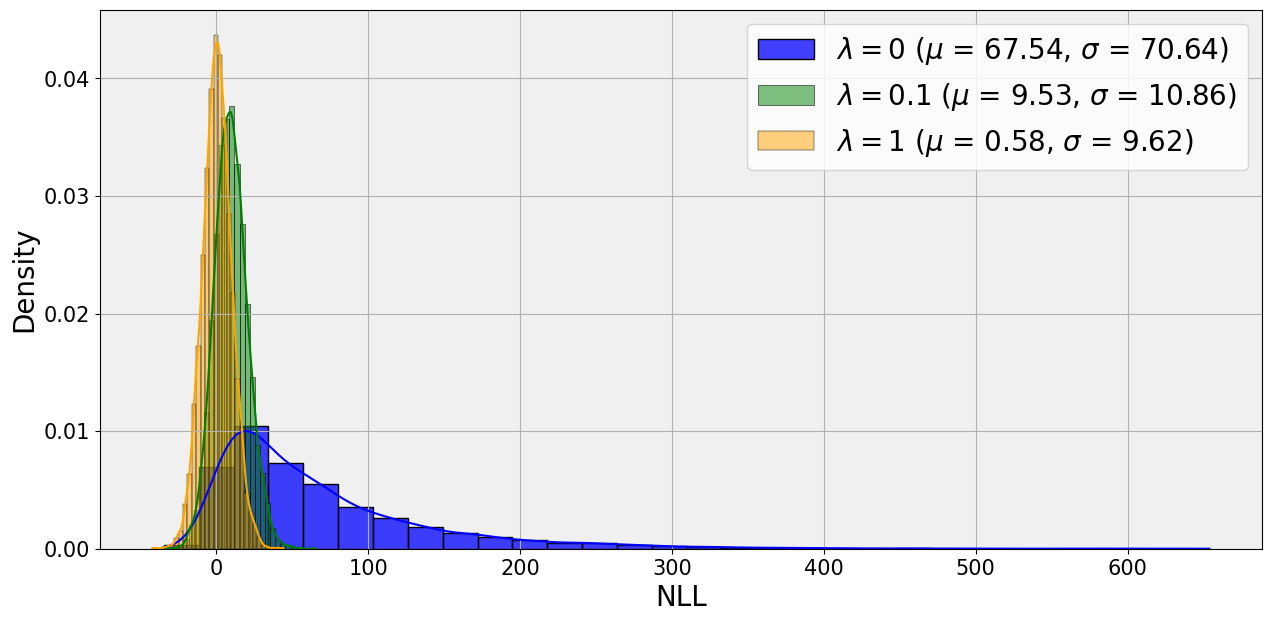

In [35]:
# Calculate means and standard deviations
mean_vanilla = np.mean(-np.array(test_diffs_vanilla))
std_vanilla = np.std(-np.array(test_diffs_vanilla))

mean_regularized = np.mean(-np.array(test_diffs_regularized))
std_regularized = np.std(-np.array(test_diffs_regularized))

mean_regularized_plus = np.mean(-np.array(test_diffs_regularized_plus))
std_regularized_plus = np.std(-np.array(test_diffs_regularized_plus))

# Create plot
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
sns.histplot(-np.array(test_diffs_vanilla), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs,
             label=f'$\\lambda = 0$ ($\\mu$ = {mean_vanilla:.2f}, $\\sigma$ = {std_vanilla:.2f})')
sns.histplot(-np.array(test_diffs_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.5, ax=axs,
             label=f'$\\lambda = 0.1$ ($\\mu$ = {mean_regularized:.2f}, $\\sigma$ = {std_regularized:.2f})')
sns.histplot(-np.array(test_diffs_regularized_plus), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs,
             label=f'$\\lambda = 1$ ($\\mu$ = {mean_regularized_plus:.2f}, $\\sigma$ = {std_regularized_plus:.2f})')

# Set labels and other plot settings
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.set_facecolor('#f0f0f0')
axs.legend()
axs.grid(True)

# Save the plot as an SVG file
plt.savefig('images/made/diff_hist_made_64.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

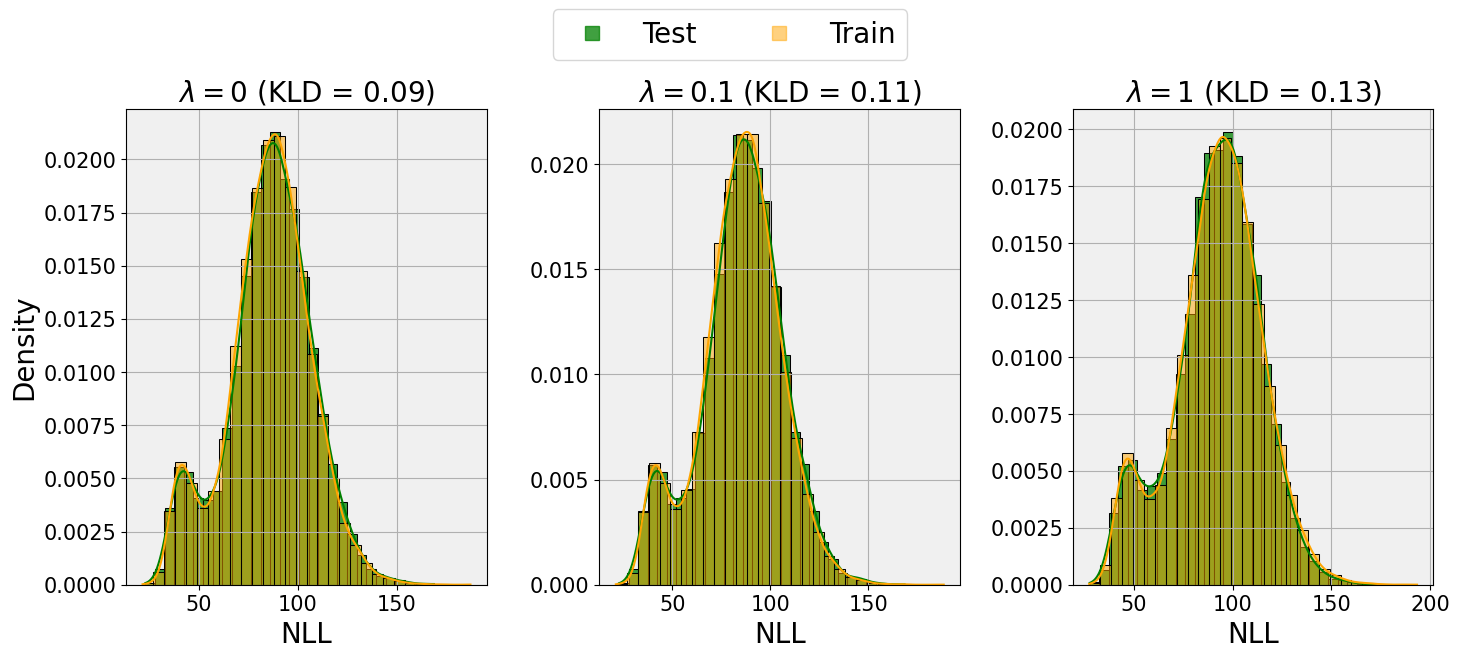

In [31]:
from scipy.stats import entropy

# Function to compute KL divergence
def compute_kl_divergence(train_data, test_data, bins=30):
    train_hist, _ = np.histogram(train_data, bins=bins, density=True)
    test_hist, _ = np.histogram(test_data, bins=bins, density=True)
    # Avoid division by zero by replacing 0 with a small number
    train_hist = np.clip(train_hist, a_min=1e-10, a_max=None)
    test_hist = np.clip(test_hist, a_min=1e-10, a_max=None)
    return entropy(test_hist, train_hist)

# Create the figure with updated size
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Compute KL divergences
kl_divergence_vanilla = compute_kl_divergence(test_lls_vanilla, train_lls_vanilla)
kl_divergence_regularized = compute_kl_divergence(test_lls_regularized, train_lls_regularized)
kl_divergence_regularized_plus = compute_kl_divergence(test_lls_regularized_plus, train_lls_regularized_plus)

# Plot for Vanilla (lambda = 0)
sns.histplot(np.array(test_lls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0], label='Test')
sns.histplot(np.array(train_lls_vanilla), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0], label='Train')
axs[0].set_title(f'$\lambda = 0$ (KLD = {kl_divergence_vanilla:.2f})')
axs[0].set_xlabel('NLL')
axs[0].set_ylabel('Density')
axs[0].set_facecolor('#f0f0f0')
axs[0].grid(True)

# Plot for Regularized (lambda = 0.1)
sns.histplot(np.array(test_lls_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1], label='Test')
sns.histplot(np.array(train_lls_regularized), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1], label='Train')
axs[1].set_title(f'$\lambda = 0.1$ (KLD = {kl_divergence_regularized:.2f})')
axs[1].set_xlabel('NLL')
axs[1].grid(True)
axs[1].set_facecolor('#f0f0f0')
axs[1].set_ylabel('')  # Remove redundant y-axis label

# Plot for Regularized (lambda = 1)
sns.histplot(np.array(test_lls_regularized_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[2], label='Test')
sns.histplot(np.array(train_lls_regularized_plus), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[2], label='Train')
axs[2].set_title(f'$\lambda = 1$ (KLD = 0.13)')
axs[2].set_xlabel('NLL')
axs[2].grid(True)
axs[2].set_facecolor('#f0f0f0')
axs[2].set_ylabel('')  # Remove redundant y-axis label

# Consolidate the legend
handles = [
    plt.Line2D([0], [0], linestyle='None', marker='s', color='green', markersize=10, alpha=0.75, label='Test'),
    plt.Line2D([0], [0], linestyle='None', marker='s', color='orange', markersize=10, alpha=0.5, label='Train')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.975))

plt.tight_layout(rect=[0, 0, 1, 0.9])

# Save the plot
plt.savefig('images/made/train_test_made_64.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# Samples

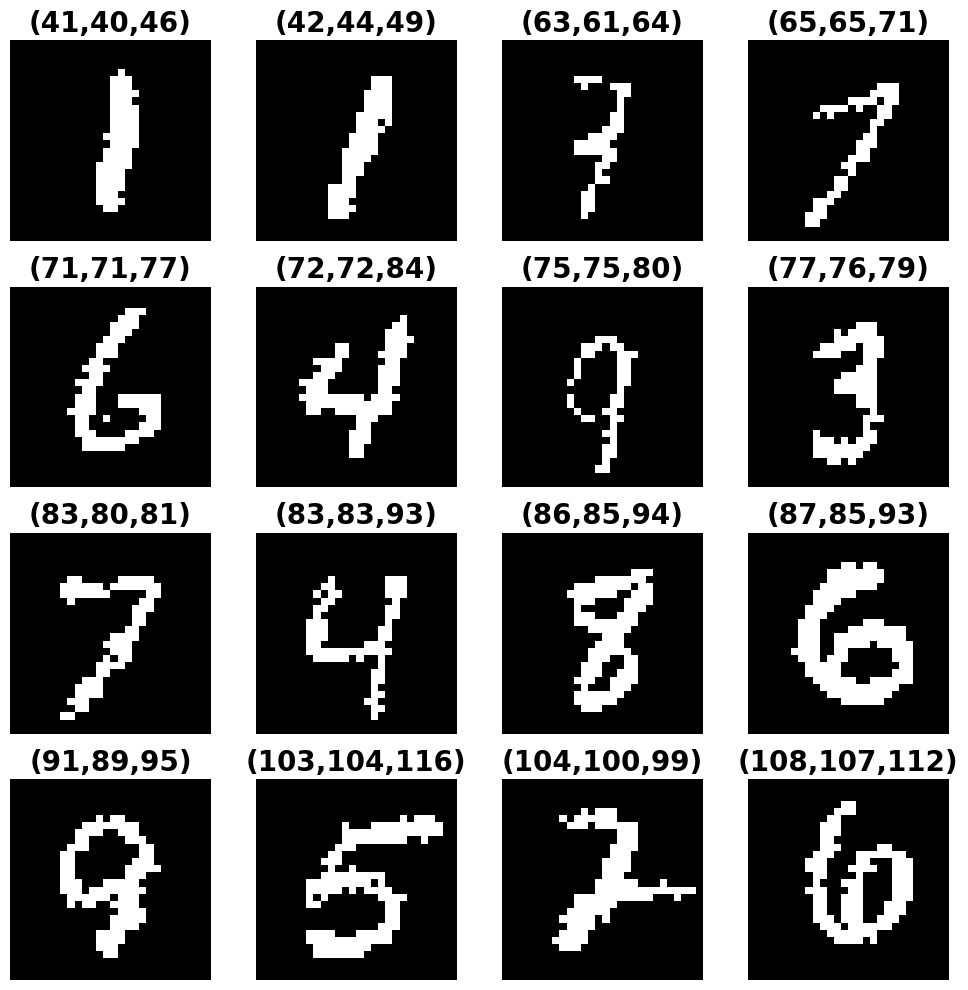

In [8]:
# Collect the images and their NLL values
image_nll_pairs = []
_, _, test_data = load_data('mnist', binarize = True, data_dir = './data')
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

for i, (x, _) in enumerate(test_loader):
    preds_vanilla = model_vanilla.forward(x)
    preds_reg = model_reg.forward(x)
    preds_reg_plus = model_reg_plus.forward(x)
    nll_vanilla = cross_entropy_loss_fn(x, preds_vanilla)
    nll_reg = cross_entropy_loss_fn(x, preds_reg)
    nll_reg_plus = cross_entropy_loss_fn(x, preds_reg_plus)
    
    image_nll_pairs.append((x.detach().numpy().reshape(28, 28), nll_vanilla.item(), nll_reg.item(), nll_reg_plus.item()))

    if i >= 15:  # Stop after collecting 100 images
        break

# Sort the images by nll_vanilla values
image_nll_pairs.sort(key=lambda pair: pair[1])

# Plot the sorted images
fig1, axes1 = plt.subplots(4, 4, figsize=(10, 10))

for i, (img, nll_vanilla, nll_reg, nll_reg_plus) in enumerate(image_nll_pairs):
    ax = axes1[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"({round(nll_vanilla)},{round(nll_reg)},{round(nll_reg_plus)})", fontsize=20, fontweight='bold')
    ax.axis('off')

fig1.tight_layout()
plt.savefig('images/made/samples_made_test.pdf', format='pdf', bbox_inches='tight')
plt.show()

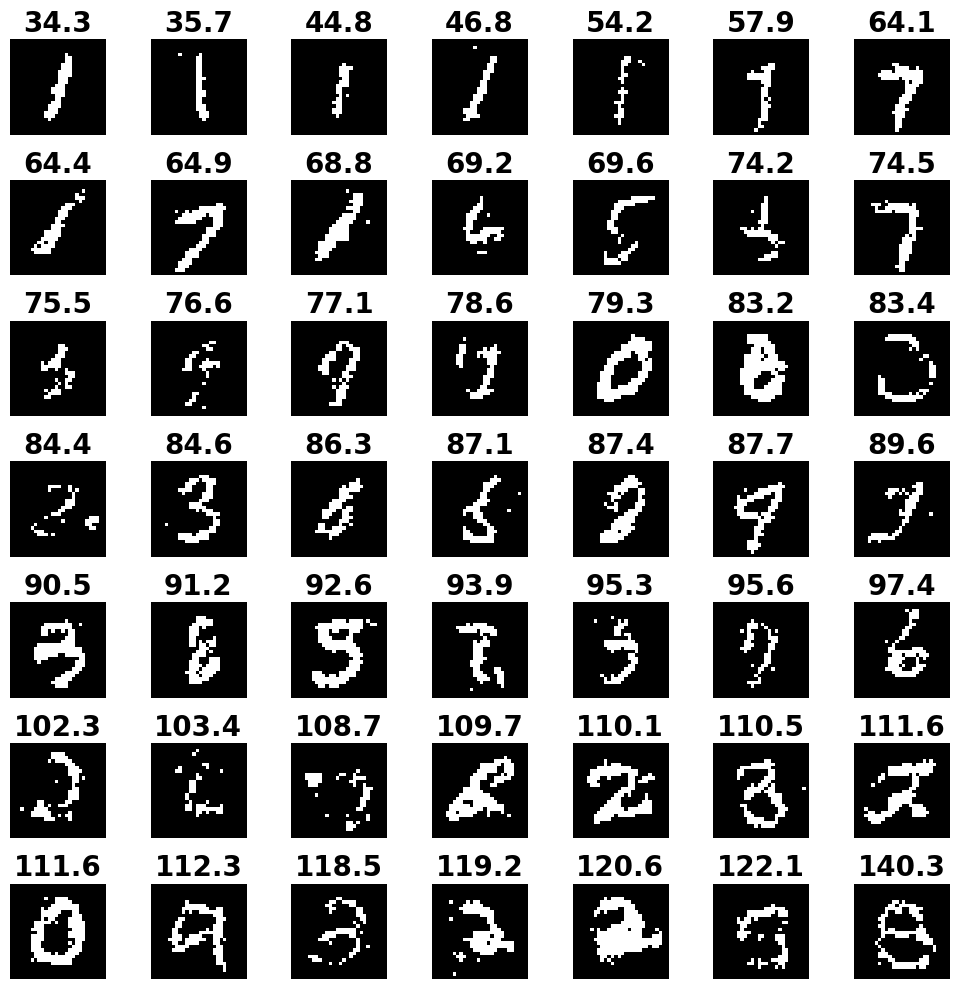

In [3]:
plot_samples(model_vanilla, 49, model_type = 'MADE', save_dir = 'images/made/samples_made_vanilla_64.pdf')

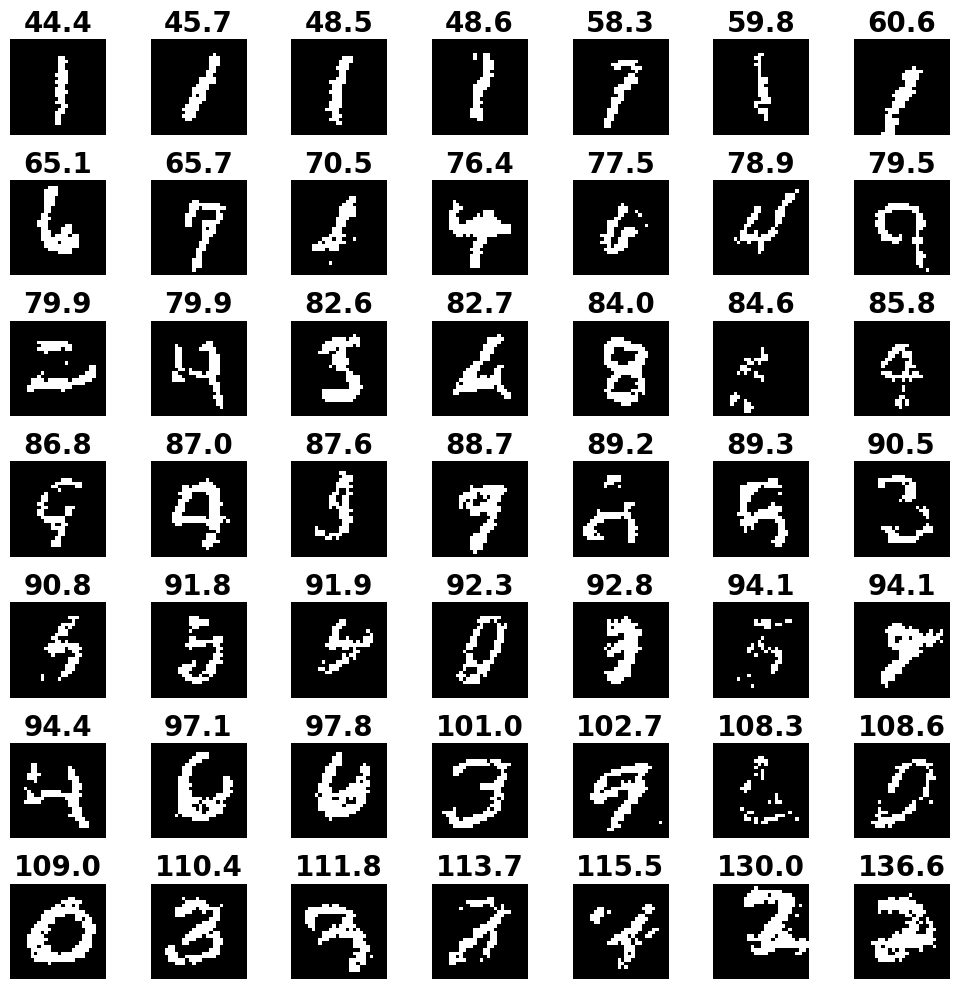

In [4]:
plot_samples(model_reg, 49, model_type = 'MADE', save_dir = 'images/made/samples_made_reg_64.pdf')

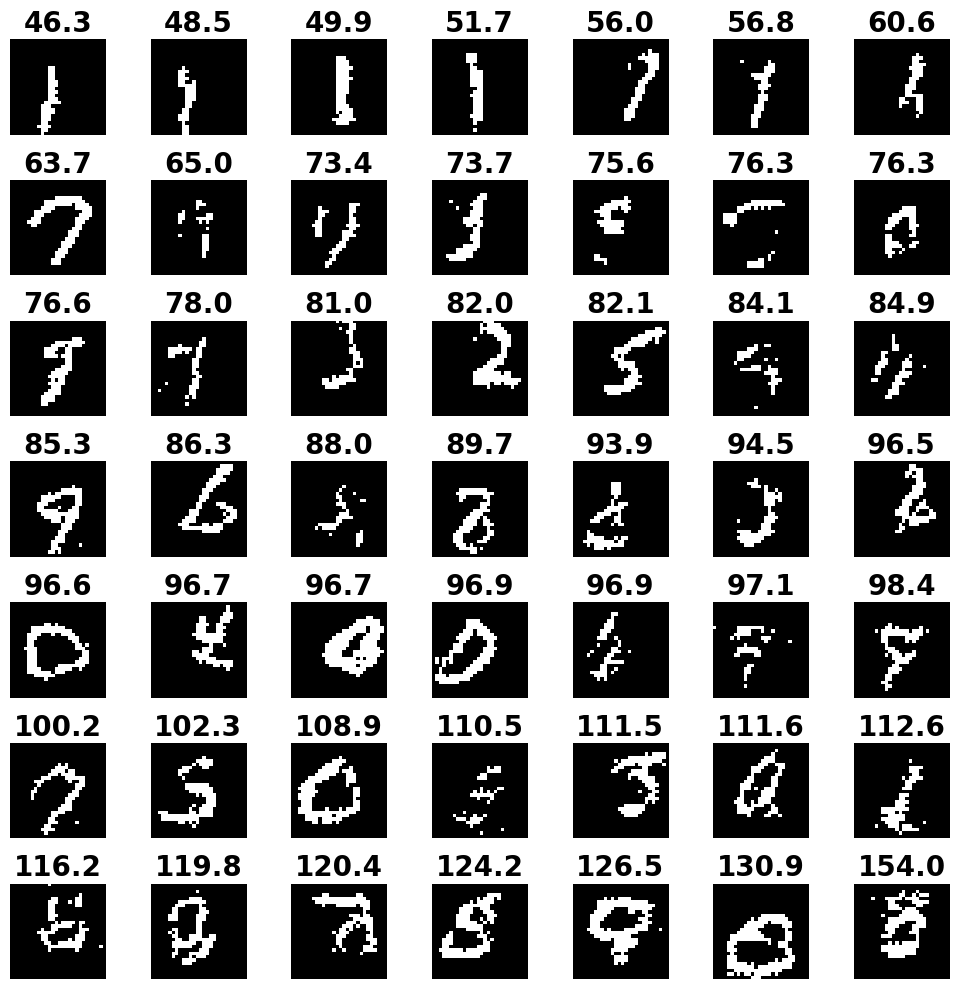

In [5]:
plot_samples(model_reg_plus, 49, model_type = 'MADE', save_dir = 'images/made/samples_made_reg_plus_64.pdf')

# Sample Quality (KID/FID/Precision/Recall)

In [52]:
with open(result_dir_vanilla + '/evaluate_results.json', 'r') as file:
    eval_dic_vanilla = json.load(file)

#with open(result_dir_reg + '/evaluate_results.json', 'r') as file:
    #eval_dic_reg = json.load(file)
eval_dic_reg = eval_dic_vanilla
#with open(result_dir_reg_plus + '/evaluate_results.json', 'r') as file:
    #eval_dic_reg = json.load(file)
eval_dic_reg_plus = eval_dic_vanilla

### KID

In [47]:
kid_mean_vanilla, kid_std_vanilla = eval_dic_vanilla['KID']['mean'], eval_dic_vanilla['KID']['std']
kid_mean_reg, kid_std_reg = eval_dic_reg['KID']['mean'], eval_dic_reg['KID']['std']
kid_mean_reg_plus, kid_std_reg_plus = eval_dic_reg_plus['KID']['mean'], eval_dic_reg_plus['KID']['std']

In [48]:
print(kid_mean_vanilla, kid_std_vanilla)
print(kid_mean_reg, kid_std_reg)
print(kid_mean_reg_plus, kid_std_reg_plus)

-0.011526711285114288 1.5249501927883102e-07
-0.011526711285114288 1.5249501927883102e-07
-0.011526711285114288 1.5249501927883102e-07


### Precision and Recall

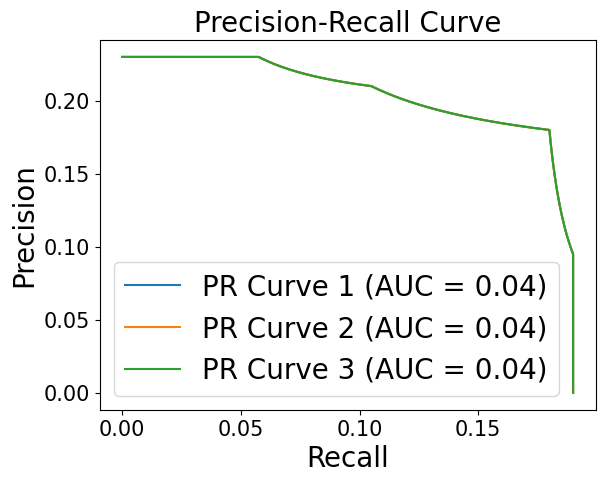

In [49]:
prd_vanilla = eval_dic_vanilla['PRD']
precisions_vanilla, recalls_vanilla = prd_vanilla['precisions'], prd_vanilla['recalls']
prd_reg = eval_dic_reg['PRD']
precisions_reg, recalls_reg = prd_reg['precisions'], prd_reg['recalls']
prd_reg_plus = eval_dic_reg_plus['PRD']
precisions_reg_plus, recalls_reg_plus = prd_reg_plus['precisions'], prd_reg_plus['recalls']
auc_vanilla = np.trapz(recalls_vanilla, precisions_vanilla)
auc_reg = np.trapz(recalls_reg, precisions_reg)
auc_reg_plus = np.trapz(recalls_reg, precisions_reg)

plt.figure()
plt.plot(precisions_vanilla, recalls_vanilla, label=f'PR Curve 1 (AUC = {auc_vanilla:.2f})')
plt.plot(precisions_reg, recalls_reg, label=f'PR Curve 2 (AUC = {auc_reg:.2f})')
plt.plot(precisions_reg_plus, recalls_reg_plus, label=f'PR Curve 3 (AUC = {auc_reg_plus:.2f})')

# Labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# Display the plot
plt.show()

# OOD Detection

### ROC/AUC

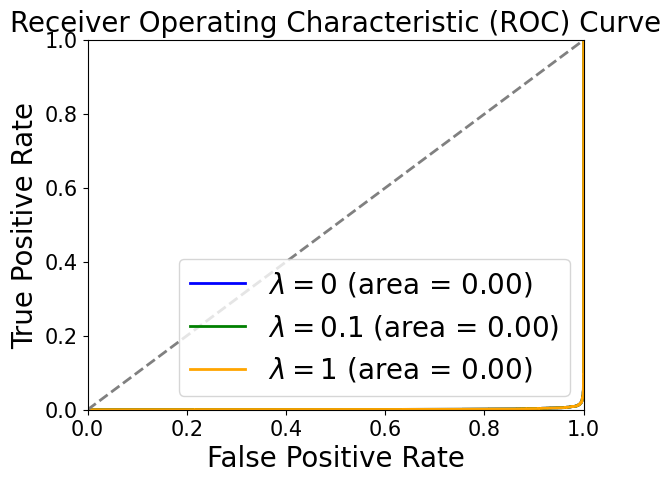

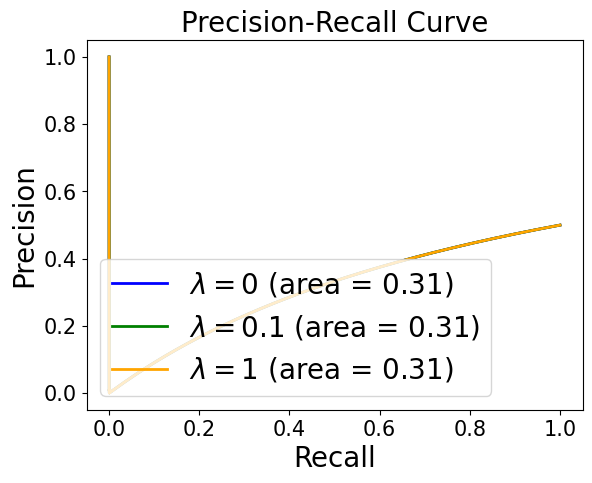

In [50]:
roc_pc_vanilla = eval_dic_vanilla['roc_pc']
fpr_vanilla, tpr_vanilla, roc_auc_vanilla, recall_vanilla, precision_vanilla, pr_auc_vanilla \
    = roc_pc_vanilla['fpr'], roc_pc_vanilla['tpr'], roc_pc_vanilla['roc_auc'], roc_pc_vanilla['recall'], \
    roc_pc_vanilla['precision'], roc_pc_vanilla['pr_auc']
roc_pc_reg = eval_dic_reg['roc_pc']
fpr_reg, tpr_reg, roc_auc_reg, recall_reg, precision_reg, pr_auc_reg = roc_pc_reg['fpr'], roc_pc_reg['tpr'], \
    roc_pc_reg['roc_auc'], roc_pc_reg['recall'], roc_pc_reg['precision'], roc_pc_reg['pr_auc']
roc_pc_reg_plus = eval_dic_reg_plus['roc_pc']
fpr_reg_plus, tpr_reg_plus, roc_auc_reg_plus, recall_reg_plus, precision_reg_plus, pr_auc_reg_plus = roc_pc_reg['fpr'], \
    roc_pc_reg_plus['tpr'], roc_pc_reg_plus['roc_auc'], roc_pc_reg_plus['recall'], roc_pc_reg_plus['precision'], roc_pc_reg_plus['pr_auc']

plt.figure()
plt.plot(fpr_vanilla, tpr_vanilla, color='blue', lw=2, label=f'$\lambda = 0$ (area = {roc_auc_vanilla:.2f})')
plt.plot(fpr_reg, tpr_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {roc_auc_reg:.2f})')
plt.plot(fpr_reg_plus, tpr_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {roc_auc_reg_plus:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall_vanilla, precision_vanilla, color='blue', lw=2, label=f'$\lambda = 0$ (area = {pr_auc_vanilla:.2f})')
plt.plot(recall_reg, precision_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {pr_auc_reg:.2f})')
plt.plot(recall_reg_plus, precision_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {pr_auc_reg_plus:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Typicality Test (Include Effect of batch size on AUC of OOD detection from Slide 43 https://www.gatsby.ucl.ac.uk/~balaji/balaji-generative-models-talk.pdf, include confidence levels?)

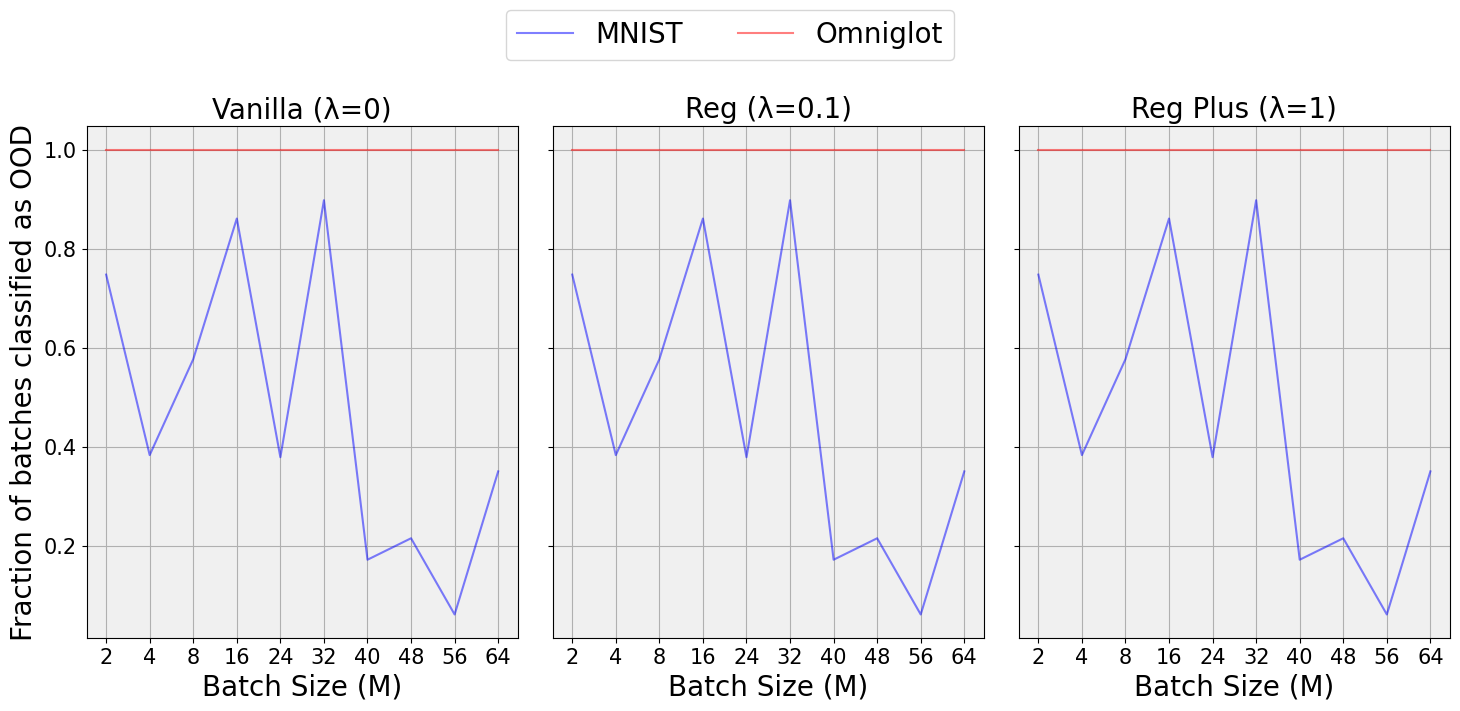

In [69]:
#https://github.com/simonwestberg/Glow
import matplotlib.pyplot as plt

# Example data setup
data_vanilla = eval_dic_vanilla['typicality']
data_reg = eval_dic_reg['typicality']
data_reg_plus = eval_dic_reg_plus['typicality']

datasets = {
    'Vanilla': data_vanilla,
    'Reg': data_reg,
    'Reg Plus': data_reg_plus
}

# Define lambda values for each dataset
lambda_values = {
    'Vanilla': 0,
    'Reg': 0.1,
    'Reg Plus': 1
}

# Create a figure with three subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(15, 7), sharey=True)

# Define the custom legend handles
handles = [
    plt.Line2D([0], [0], linestyle='-', color='blue', alpha=0.5, label='MNIST'),
    plt.Line2D([0], [0], linestyle='-', color='red', alpha=0.5, label='Omniglot')
]

# Plotting on each subplot
for i, (ax, (label, data)) in enumerate(zip(axs, datasets.items())):
    lambda_value = lambda_values[label]  # Get the lambda value for the current dataset
    M_values = list(data.keys())
    mnist_values = [data[m]['mnist'] for m in M_values]
    omniglot_values = [data[m]['omniglot'] for m in M_values]

    # Remove 'M=' prefix for tick labels
    M_values = [m.split('=')[1] for m in M_values]
    
    # Plot the data
    ax.plot(M_values, mnist_values, linestyle='-', color='blue', alpha=0.5)
    ax.plot(M_values, omniglot_values, linestyle='-', color='red', alpha=0.5)
    
    ax.set_xlabel('Batch Size (M)')
    if i == 0:
        ax.set_ylabel('Fraction of batches classified as OOD')
    ax.set_title(f'{label} (λ={lambda_value})')
    ax.grid(True)
    ax.set_facecolor('#f0f0f0')

    # Remove y-axis labels for the second and third subplots
    if i > 0:
        ax.set_ylabel('')

# Place the consolidated legend above the plots
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to make space for the legend

# Save the figure
#fig.savefig('images/made/ood_mnist_omniglot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()






### Visualization

In [70]:
ood_lls_vanilla = eval_dic_vanilla['OOD_NLLs_test']
test_lls_mnist_vanilla, test_lls_omniglot_vanilla = ood_lls_vanilla['mnist'], ood_lls_vanilla['omniglot']
ood_lls_reg = eval_dic_reg['OOD_NLLs_test']
test_lls_mnist_reg, test_lls_omniglot_reg = ood_lls_reg['mnist'], ood_lls_reg['omniglot']
ood_lls_reg_plus = eval_dic_reg_plus['OOD_NLLs_test']
test_lls_mnist_reg_plus, test_lls_omniglot_reg_plus = ood_lls_reg_plus['mnist'], ood_lls_reg_plus['omniglot']

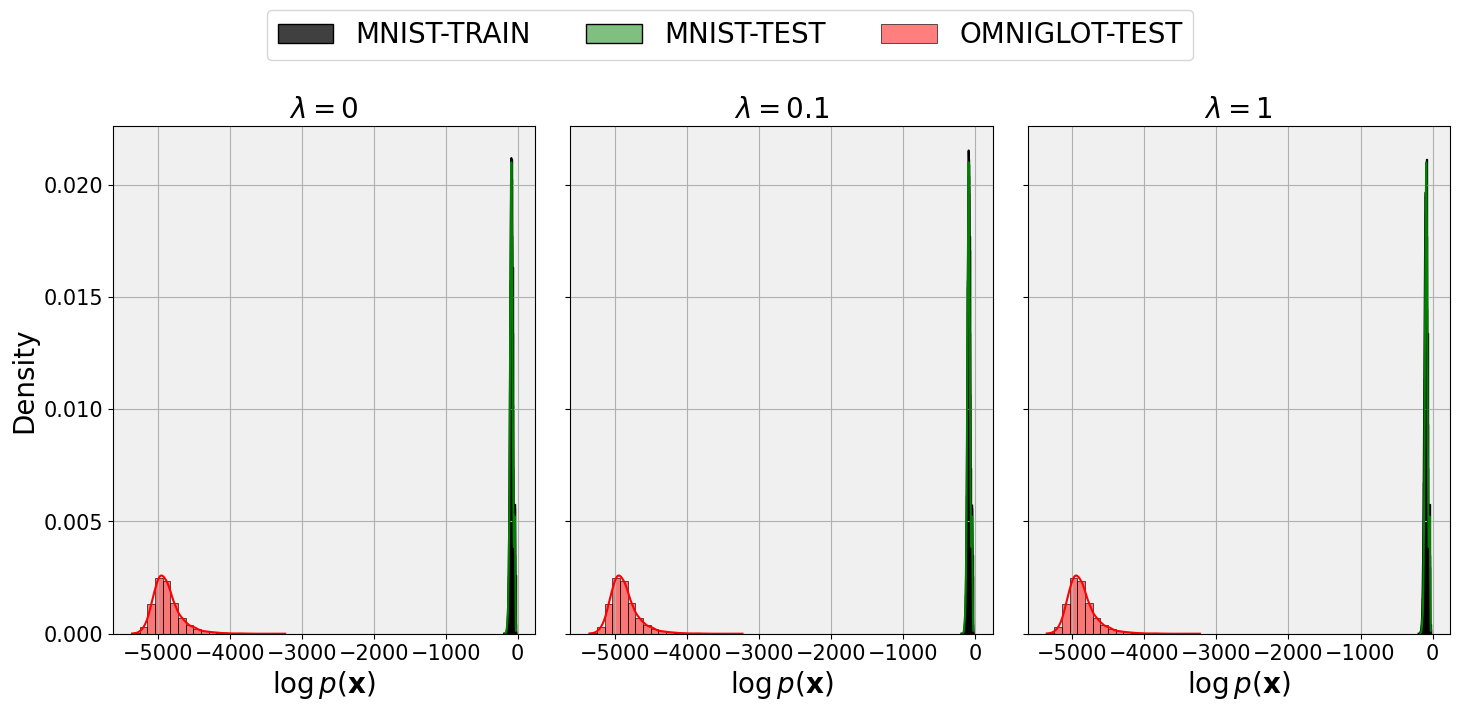

In [71]:
# Assuming train_lls_vanilla, test_lls_mnist_vanilla, test_lls_emnist_vanilla, etc. are defined
# and contain the log-likelihoods for the respective datasets and regularization settings

fig, axs = plt.subplots(1, 3, figsize=(15, 7), sharey=True)

# Vanilla (lambda = 0)
sns.histplot(-np.array(train_lls_vanilla), bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[0], label='MNIST-TRAIN')
sns.histplot(-np.array(test_lls_mnist_vanilla), bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[0], label='MNIST-TEST')
sns.histplot(-np.array(test_lls_omniglot_vanilla), bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[0], label='OMNIGLOT-TEST')
axs[0].set_title('$\lambda = 0$')
axs[0].set_xlabel(r'$\log p(\mathbf{x})$')
axs[0].set_ylabel('Density')
axs[0].grid(True)
axs[0].set_facecolor('#f0f0f0')

# Regularized (lambda = 0.1)
sns.histplot(-np.array(train_lls_regularized), bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[1])
sns.histplot(-np.array(test_lls_mnist_reg), bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[1])
sns.histplot(-np.array(test_lls_omniglot_reg), bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[1])
axs[1].set_title('$\lambda = 0.1$')
axs[1].set_xlabel(r'$\log p(\mathbf{x})$')
axs[1].grid(True)
axs[1].set_ylabel('')  # Remove redundant y-axis label
axs[1].set_facecolor('#f0f0f0')

# Regularized Plus (lambda = 1)
sns.histplot(-np.array(train_lls_regularized_plus), bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[2])
sns.histplot(-np.array(test_lls_mnist_reg_plus), bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[2])
sns.histplot(-np.array(test_lls_omniglot_reg_plus), bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[2])
axs[2].set_title('$\lambda = 1$')
axs[2].set_xlabel(r'$\log p(\mathbf{x})$')
axs[2].grid(True)
axs[2].set_ylabel('')  # Remove redundant y-axis label
axs[2].set_facecolor('#f0f0f0')

# Combine the legends into one at the top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/made/ood_histograms_mnist_omniglot.pdf', format='pdf', bbox_inches='tight')

plt.show()
